# Mapping crimes in Boyle Heights

In [1]:
# https://github.com/dnanhkhoa/nb_black
%load_ext lab_black

### Import data tools

In [119]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import fiona
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import altair as alt
import altair_latimes as lat

alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Run if most-recent data is needed

In [49]:
# %run '00-lapd-crimes-processing.ipynb'

### Read crimes CSV downloaded from LA City data portal

In [53]:
crimes = pd.read_csv(
    "/Users/mhustiles/data/data/LA/crimes.csv",
    dtype={
        "area_name": str,
        "rpt_dist_no": str,
        "weapon_used_cd": str,
        "crm_cd": str,
        "premises_code": str,
        "division": str,
    },
)

In [134]:
test = pd.read_csv("output/bh_homicides.csv")

In [133]:
test.head()

record_id date_reported date_occurred  time_occurred division_name  \
0  200405562    2020-02-10    2020-02-10            200    Hollenbeck   
1  200407038    2020-03-17    2020-03-17            905    Hollenbeck   
2  200401071    2020-09-26    2020-09-26            900    Hollenbeck   
3  200407880    2020-04-16    2020-04-15           2259    Hollenbeck   
4  200408872    2020-05-15    2020-05-15            710    Hollenbeck   

   reporting_district crime_code_description  \
0                 449      Criminal homicide   
1                 478      Criminal homicide   
2                 453      Criminal homicide   
3                 466      Criminal homicide   
4                 453      Criminal homicide   

                                 modus_operandi_code  victim_age victim_sex  \
0            0913 1100 1402 0430 1820 0302 1309 0906        29.0       male   
1  0302 0334 0430 0202 0906 1100 2004 1407 1822 0341        26.0       male   
2                           1822 0400 0416 0429 1202        62.0       male   
3       1402 1407 0946 1270 1809 1822 1100 0906 0430        45.0       male   
4                 0906 1822 1100 0430 0334 1407 0302        40.0       male   

     premises_description                              weapon_description  \
0  Single family dwelling                           Semi-automatic pistol   
1                Sidewalk                           Semi-automatic pistol   
2                  Street  Strong-arm (hands, fist, feet or bodily force)   
3             Parking lot                                        Hand gun   
4         Park/playground                                        Hand gun   

  status_code_description                                  address  latitude  \
0            adult_arrest  2600    MARENGO                      ST   34.0545   
1            adult_arrest   900    GRANDE VISTA                 AV   34.0280   
2             invest_cont  1800    PENNSYLVANIA                 AV   34.0475   
3            adult_arrest  2800 E  CESAR E CHAVEZ               AV   34.0445   
4             invest_cont   700    ECHANDIA                     ST   34.0542   

   longitude  division.1  year  quarter  day  month  weekday  monthname  \
0  -118.1992         NaN  2020        1   10      2        0   February   
1  -118.2048         NaN  2020        1   17      3        1      March   
2  -118.2169         NaN  2020        3   26      9        5  September   
3  -118.2025         NaN  2020        2   15      4        2      April   
4  -118.2172         NaN  2020        2   15      5        4        May   

  descent_description  hour  minute                   geometry  index_right  \
0            hispanic     2       0  POINT (-118.1992 34.0545)            9   
1            hispanic     9       5   POINT (-118.2048 34.028)            9   
2            hispanic     9       0  POINT (-118.2169 34.0475)            9   
3            hispanic    22      59  POINT (-118.2025 34.0445)            9   
4            hispanic     7      10  POINT (-118.2172 34.0542)            9   

            name  
0  Boyle Heights  
1  Boyle Heights  
2  Boyle Heights  
3  Boyle Heights  
4  Boyle Heights

In [56]:
crimes.drop(
    [
        "crime_code",
        "victim_descent",
        "division",
        "part_type",
        "crime_code",
        "weapon_code",
        "status_code",
        "crm_cd_1",
        "crm_cd_2",
        "crm_cd_3",
        "crm_cd_4",
        "cross_street",
        "part_category",
        "premises_code",
    ],
    axis=1,
    inplace=True,
)

### How many Part 1 crimes? 

In [57]:
len(crimes)

In [58]:
crimes.head()

record_id date_reported date_occurred  time_occurred division_name  \
0  200100501    2020-01-02    2020-01-01             30       Central   
1  200100502    2020-01-02    2020-01-02           1315       Central   
2  200100507    2020-01-04    2020-01-04            200       Central   
3  200100509    2020-01-04    2020-01-04           2200       Central   
4  200100514    2020-01-05    2020-01-05           1355       Central   

   reporting_district                             crime_code_description  \
0                 163                                     Rape, forcible   
1                 161           Shoplifting - petty theft ($950 & under)   
2                 101  Theft-grand ($950.01 & over)excpt,guns,fowl,li...   
3                 192                              Burglary from vehicle   
4                 162  Theft-grand ($950.01 & over)excpt,guns,fowl,li...   

   modus_operandi_code  victim_age victim_sex  \
0  0413 1822 1262 1415        25.0     female   
1  1402 2004 0344 0387        23.0       male   
2       1822 0344 1402        23.0       male   
3  1822 1414 0344 1307        29.0       male   
4       1822 0344 2032        41.0       male   

                           premises_description           weapon_description  \
0               Night club (open evenings only)  Unknown weapon/other weapon   
1                              Department store                          NaN   
2  Multi-unit dwelling (apartment, duplex, etc)                          NaN   
3                                        Street           Rock/thrown object   
4                                         Hotel                          NaN   

  status_code_description                                 address  latitude  \
0             invest_cont                         700 S  BROADWAY   34.0452   
1             invest_cont  700 S  FIGUEROA                     ST   34.0483   
2             invest_cont  700    BERNARD                      ST   34.0677   
3             invest_cont                                    15TH   34.0359   
4            adult_arrest  800 S  OLIVE                        ST   34.0452   

   longitude  division.1  year  quarter  day  month  weekday monthname  \
0  -118.2534         NaN  2020        1    1      1        2   January   
1  -118.2631         NaN  2020        1    2      1        3   January   
2  -118.2398         NaN  2020        1    4      1        5   January   
3  -118.2648         NaN  2020        1    4      1        5   January   
4  -118.2569         NaN  2020        1    5      1        6   January   

  descent_description  hour  minute  
0            hispanic     0      30  
1            hispanic    13      15  
2               black     2       0  
3               asian    22       0  
4               asian    13      55

### Boyle Heights spans across parts of three LAPD districts. Let's isolate the data frame to them for now

In [59]:
boyle_area_divisions = ["Central", "Hollenbeck", "Newton"]

In [60]:
boyle_area_divisions

['Central', 'Hollenbeck', 'Newton']

In [61]:
boyle_heights_area_crimes = crimes[crimes["division_name"].isin(boyle_area_divisions)]

### How many Part 1 crimes are looking at now? 

In [62]:
len(boyle_heights_area_crimes)

In [63]:
boyle_heights_area_crimes.head()

record_id date_reported date_occurred  time_occurred division_name  \
0  200100501    2020-01-02    2020-01-01             30       Central   
1  200100502    2020-01-02    2020-01-02           1315       Central   
2  200100507    2020-01-04    2020-01-04            200       Central   
3  200100509    2020-01-04    2020-01-04           2200       Central   
4  200100514    2020-01-05    2020-01-05           1355       Central   

   reporting_district                             crime_code_description  \
0                 163                                     Rape, forcible   
1                 161           Shoplifting - petty theft ($950 & under)   
2                 101  Theft-grand ($950.01 & over)excpt,guns,fowl,li...   
3                 192                              Burglary from vehicle   
4                 162  Theft-grand ($950.01 & over)excpt,guns,fowl,li...   

   modus_operandi_code  victim_age victim_sex  \
0  0413 1822 1262 1415        25.0     female   
1  1402 2004 0344 0387        23.0       male   
2       1822 0344 1402        23.0       male   
3  1822 1414 0344 1307        29.0       male   
4       1822 0344 2032        41.0       male   

                           premises_description           weapon_description  \
0               Night club (open evenings only)  Unknown weapon/other weapon   
1                              Department store                          NaN   
2  Multi-unit dwelling (apartment, duplex, etc)                          NaN   
3                                        Street           Rock/thrown object   
4                                         Hotel                          NaN   

  status_code_description                                 address  latitude  \
0             invest_cont                         700 S  BROADWAY   34.0452   
1             invest_cont  700 S  FIGUEROA                     ST   34.0483   
2             invest_cont  700    BERNARD                      ST   34.0677   
3             invest_cont                                    15TH   34.0359   
4            adult_arrest  800 S  OLIVE                        ST   34.0452   

   longitude  division.1  year  quarter  day  month  weekday monthname  \
0  -118.2534         NaN  2020        1    1      1        2   January   
1  -118.2631         NaN  2020        1    2      1        3   January   
2  -118.2398         NaN  2020        1    4      1        5   January   
3  -118.2648         NaN  2020        1    4      1        5   January   
4  -118.2569         NaN  2020        1    5      1        6   January   

  descent_description  hour  minute  
0            hispanic     0      30  
1            hispanic    13      15  
2               black     2       0  
3               asian    22       0  
4               asian    13      55

---

## Import mapping data

In [64]:
# Transform our crimes data into a geoDataFrame
boyle_heights_area_crimes_geo = gpd.GeoDataFrame(
    boyle_heights_area_crimes,
    geometry=gpd.points_from_xy(
        boyle_heights_area_crimes.longitude, boyle_heights_area_crimes.latitude
    ),
)

### Set the geographic file's coordinate reference system

In [65]:
boyle_heights_area_crimes_geo = boyle_heights_area_crimes_geo.set_crs("EPSG:4326")
boyle_heights_area_crimes_geo = boyle_heights_area_crimes_geo.set_crs(epsg=4326)

### Read LAPD reporting districts

In [66]:
districts = gpd.read_file("input/LAPD_Reporting_Districts/LAPD_Reporting_Districts.shp")

### Read LAPD divisions

In [67]:
divisions = gpd.read_file("input/LAPD_Divisions/LAPD_Divisions.shp")

### Read LA Times neighborhoods

In [68]:
hoods = gpd.read_file("input/custom-la-hoods-skid-row.geojson")

---

## Isolate just Boyle Heights crimes

### First, get the neighborhood boundary

In [74]:
boyle_heights = hoods[hoods["name"] == "Boyle Heights"]

<AxesSubplot:>

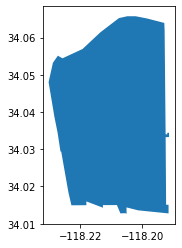

In [76]:
boyle_heights.plot()

### Next, get only those crimes within the boundaries by performing a spatial merge

In [77]:
bh_crimes = gpd.sjoin(
    boyle_heights_area_crimes_geo, boyle_heights, how="inner", op="within"
)

### Did it work? 

<AxesSubplot:>

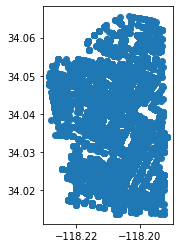

In [78]:
bh_crimes.plot()

### How many crimes now? 

In [79]:
len(bh_crimes)

17696

---

## Basic aggregates on variables for all crimes

### Which crimes are most common? 

In [80]:
violations = (
    bh_crimes.groupby(["crime_code_description"])
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [83]:
violations.head()

crime_code_description  total
40                                 Vehicle - stolen   4232
34               Theft plain - petty ($950 & under)   2287
2    Assault with deadly weapon, aggravated assault   1963
8                             Burglary from vehicle   1759
31  Theft from motor vehicle - petty ($950 & under)   1463

### Places where crimes occur?

In [84]:
places = (
    bh_crimes.groupby(["premises_description"])
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [85]:
places.head(5)

premises_description  total
108                  Street   7620
86              Parking lot   1683
104  Single family dwelling   1552
103                Sidewalk    944
80           Other business    893

### Aggregates for police geography

In [23]:
divisions = (
    bh_crimes.groupby(["division_name", "crime_code_description", "year"])
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [24]:
divisions.head()

division_name crime_code_description  year  total
280    Hollenbeck       Vehicle - stolen  2020    711
278    Hollenbeck       Vehicle - stolen  2015    599
273    Hollenbeck       Vehicle - stolen  2010    597
275    Hollenbeck       Vehicle - stolen  2012    549
277    Hollenbeck       Vehicle - stolen  2014    517

In [25]:
districts = (
    bh_crimes.groupby(
        ["reporting_district", "division_name", "crime_code_description", "year"]
    )
    .agg("size")
    .reset_index(name="total")
    .sort_values(by="total", ascending=False)
)

In [26]:
districts.head()

reporting_district division_name crime_code_description  year  total
3522                 497    Hollenbeck       Vehicle - stolen  2020     70
3515                 497    Hollenbeck       Vehicle - stolen  2010     69
3640                 499    Hollenbeck       Vehicle - stolen  2020     61
3517                 497    Hollenbeck       Vehicle - stolen  2012     53
3520                 497    Hollenbeck       Vehicle - stolen  2015     53

---

## Boyle Heights homicides

In [95]:
bh_homicides = gpd.GeoDataFrame(
    bh_crimes[bh_crimes["crime_code_description"] == "Criminal homicide"]
)

In [96]:
bh_homicides.head()

record_id date_reported date_occurred  time_occurred division_name  \
17914  200405562    2020-02-10    2020-02-10            200    Hollenbeck   
30992  200407038    2020-03-17    2020-03-17            905    Hollenbeck   
36689  200401071    2020-09-26    2020-09-26            900    Hollenbeck   
50062  200407880    2020-04-16    2020-04-15           2259    Hollenbeck   
50373  200408872    2020-05-15    2020-05-15            710    Hollenbeck   

       reporting_district crime_code_description  \
17914                 449      Criminal homicide   
30992                 478      Criminal homicide   
36689                 453      Criminal homicide   
50062                 466      Criminal homicide   
50373                 453      Criminal homicide   

                                     modus_operandi_code  victim_age  \
17914            0913 1100 1402 0430 1820 0302 1309 0906        29.0   
30992  0302 0334 0430 0202 0906 1100 2004 1407 1822 0341        26.0   
36689                           1822 0400 0416 0429 1202        62.0   
50062       1402 1407 0946 1270 1809 1822 1100 0906 0430        45.0   
50373                 0906 1822 1100 0430 0334 1407 0302        40.0   

      victim_sex    premises_description  \
17914       male  Single family dwelling   
30992       male                Sidewalk   
36689       male                  Street   
50062       male             Parking lot   
50373       male         Park/playground   

                                   weapon_description status_code_description  \
17914                           Semi-automatic pistol            adult_arrest   
30992                           Semi-automatic pistol            adult_arrest   
36689  Strong-arm (hands, fist, feet or bodily force)             invest_cont   
50062                                        Hand gun            adult_arrest   
50373                                        Hand gun             invest_cont   

                                       address  latitude  longitude  \
17914  2600    MARENGO                      ST   34.0545  -118.1992   
30992   900    GRANDE VISTA                 AV   34.0280  -118.2048   
36689  1800    PENNSYLVANIA                 AV   34.0475  -118.2169   
50062  2800 E  CESAR E CHAVEZ               AV   34.0445  -118.2025   
50373   700    ECHANDIA                     ST   34.0542  -118.2172   

       division.1  year  quarter  day  month  weekday  monthname  \
17914         NaN  2020        1   10      2        0   February   
30992         NaN  2020        1   17      3        1      March   
36689         NaN  2020        3   26      9        5  September   
50062         NaN  2020        2   15      4        2      April   
50373         NaN  2020        2   15      5        4        May   

      descent_description  hour  minute                     geometry  \
17914            hispanic     2       0  POINT (-118.19920 34.05450)   
30992            hispanic     9       5  POINT (-118.20480 34.02800)   
36689            hispanic     9       0  POINT (-118.21690 34.04750)   
50062            hispanic    22      59  POINT (-118.20250 34.04450)   
50373            hispanic     7      10  POINT (-118.21720 34.05420)   

       index_right           name  
17914            9  Boyle Heights  
30992            9  Boyle Heights  
36689            9  Boyle Heights  
50062            9  Boyle Heights  
50373            9  Boyle Heights

### Plot the homicides by year

In [98]:
bh_homicides_yr = bh_homicides.groupby(["year"]).agg("size").reset_index(name="count")

In [99]:
bh_homicides_yr.year = bh_homicides_yr.year.astype(str)

In [103]:
lines = (
    alt.Chart(
        bh_homicides_yr,
        title="Boyle Heights homicides, by year",
    )
    .mark_bar()
    .encode(
        x=alt.X(
            "year:N",
            axis=alt.Axis(grid=False, title=""),
        ),
        y=alt.Y(
            "count:Q",
            scale=alt.Scale(domain=(0, 25)),
            axis=alt.Axis(
                gridColor="#dddddd",
                offset=6,
                tickSize=0,
                domainOpacity=0,
                tickCount=6,
                title="Homicides",
            ),
        ),
    )
)

# go
(lines).properties(height=400, width=320).configure_view(strokeOpacity=0)

alt.Chart(...)

In [101]:
alt.Chart(bh_homicides_yr).mark_bar().encode(x="year:N", y="count:Q")

alt.Chart(...)

---

## Descriptives

### Where are these homicides occuring? 

Rougly half occurr on streets and sidewalks

In [104]:
round(bh_homicides.premises_description.value_counts("normalize") * 100)

Street                                                29.0
Sidewalk                                              21.0
Parking lot                                           12.0
Single family dwelling                                 8.0
Multi-unit dwelling (apartment, duplex, etc)           5.0
Alley                                                  3.0
Driveway                                               3.0
Porch, residential                                     3.0
Yard (residential/business)                            2.0
Other/outside                                          2.0
Freeway                                                2.0
Park/playground                                        2.0
Government facility (federal,state, county & city)     1.0
Vacant lot                                             1.0
Mta - gold line - soto                                 1.0
Project/tenement/public housing                        1.0
Other premise                                          1

### What times do these homicides occur? 

About 30% happen between 10pm and 2 am, it seems

In [105]:
bh_homicides_slim = bh_homicides[
    [
        "date_occurred",
        "hour",
        "victim_age",
        "victim_sex",
        "premises_description",
        "descent_description",
        "status_code_description",
    ]
]

In [107]:
alt.Chart(bh_homicides_slim).mark_bar().encode(
    alt.X("hour:Q", bin=alt.Bin(maxbins=24)),
    y="count()",
)

alt.Chart(...)

### What's the share of 10pm-2am homicides?

In [108]:
all_homicides = len(bh_homicides_slim)

In [109]:
midnight_homicides = len(
    bh_homicides_slim[
        (bh_homicides_slim["hour"] > 22) | (bh_homicides_slim["hour"] < 3)
    ]
)

In [110]:
round((midnight_homicides / all_homicides) * 100, 2)

29.07

### Have the cases been resolved? 

Half remain unsolved

In [111]:
round(bh_homicides_slim.status_code_description.value_counts("normalize") * 100)

invest_cont     52.0
adult_arrest    41.0
adult_other      5.0
juv_arrest       2.0
Name: status_code_description, dtype: float64

### What is the average age of the victims? 

In [112]:
round(bh_homicides_slim.victim_age.mean())

30

### Most of the victims are men ...

In [113]:
round(bh_homicides_slim.victim_sex.value_counts("normalize") * 100)

male       88.0
female     10.0
unknown     1.0
Name: victim_sex, dtype: float64

### ... and Latino

In [114]:
round(bh_homicides_slim.descent_description.value_counts("normalize") * 100)

hispanic    95.0
white        3.0
other        1.0
Name: descent_description, dtype: float64

---

## Geography

In [115]:
bh_homicides.sort_values("date_occurred", ascending=False).head()

record_id date_reported date_occurred  time_occurred division_name  \
114580  210404306    2021-01-09    2021-01-09           2048    Hollenbeck   
113784  210404049    2021-01-02    2021-01-02           1530    Hollenbeck   
111593  200416452    2020-12-31    2020-12-31            855    Hollenbeck   
112342  200416098    2020-12-19    2020-12-19           1719    Hollenbeck   
111747  200416099    2020-12-19    2020-12-19           1719    Hollenbeck   

        reporting_district crime_code_description       modus_operandi_code  \
114580                 456      Criminal homicide            1100 1822 0430   
113784                 453      Criminal homicide  0906 1822 0430 1402 1100   
111593                 497      Criminal homicide       1100 1822 1218 0430   
112342                 464      Criminal homicide       1822 0430 1100 0906   
111747                 464      Criminal homicide            1822 0430 0906   

        victim_age victim_sex premises_description weapon_description  \
114580        59.0       male               Street           Hand gun   
113784        15.0       male           Vacant lot           Hand gun   
111593        45.0       male        Other/outside    Unknown firearm   
112342        23.0     female               Street           Hand gun   
111747        22.0       male               Street           Hand gun   

       status_code_description                                  address  \
114580             invest_cont   700 N  FICKETT                      ST   
113784             invest_cont   600    ECHANDIA                     ST   
111593             invest_cont  2800 E  LUGO                         ST   
112342            adult_arrest   200 S  SOTO                         ST   
111747            adult_arrest   200 S  SOTO                         ST   

        latitude  longitude  division.1  year  quarter  day  month  weekday  \
114580   34.0495  -118.2036         NaN  2021        1    9      1        5   
113784   34.0527  -118.2183         NaN  2021        1    2      1        5   
111593   34.0166  -118.2200         NaN  2020        4   31     12        3   
112342   34.0445  -118.2116         NaN  2020        4   19     12        5   
111747   34.0445  -118.2116         NaN  2020        4   19     12        5   

       monthname descent_description  hour  minute  \
114580   January            hispanic    20      48   
113784   January            hispanic    15      30   
111593  December            hispanic     8      55   
112342  December            hispanic    17      19   
111747  December            hispanic    17      19   

                           geometry  index_right           name  
114580  POINT (-118.20360 34.04950)            9  Boyle Heights  
113784  POINT (-118.21830 34.05270)            9  Boyle Heights  
111593  POINT (-118.22000 34.01660)            9  Boyle Heights  
112342  POINT (-118.21160 34.04450)            9  Boyle Heights  
111747  POINT (-118.21160 34.04450)            9  Boyle Heights

### 2010-2021 homicides

In [116]:
# Boyle Heights neighborhood background
background = (
    alt.Chart(boyle_heights)
    .mark_geoshape(fill="lightgray", stroke="white")
    .properties(width=500, height=800)
)

# homicide positions on background
points = (
    alt.Chart(bh_homicides)
    .mark_circle(size=150)
    .encode(
        longitude="longitude:Q",
        latitude="latitude:Q",
        color=alt.Color("year:N", scale=alt.Scale(scheme="category10")),
        tooltip=[
            "record_id:N",
            "year:N",
            "date_occurred:N",
            "premises_description:N",
            "weapon_description:N",
        ],
    )
)

(background + points).properties(height=600, width=300).configure_legend(
    symbolType="circle", symbolSize=70
)

alt.LayerChart(...)

### 2020 homicides

In [118]:
# Boyle Heights neighborhood background
background = (
    alt.Chart(boyle_heights)
    .mark_geoshape(fill="lightgray", stroke="white")
    .properties(width=500, height=800)
)

# homicide positions on background
points = (
    alt.Chart(bh_homicides.query("year == 2020"))
    .mark_circle(size=150)
    .encode(
        longitude="longitude:Q",
        latitude="latitude:Q",
        color=alt.Color("year:N", scale=alt.Scale(scheme="category10")),
        tooltip=[
            "record_id:N",
            "year:N",
            "date_occurred:N",
            "premises_description:N",
            "weapon_description:N",
        ],
    )
)

(background + points).properties(height=600, width=300).configure_legend(
    symbolType="circle", symbolSize=70
)

alt.LayerChart(...)

---

## Export

In [120]:
bh_homicides.to_file("output/bh_homicides.geojson", driver="GeoJSON")

In [121]:
bh_homicides[bh_homicides["year"] == 2020].to_file(
    "output/bh_homicides_2020.geojson", driver="GeoJSON"
)

In [122]:
fiona.supported_drivers["KML"] = "rw"
bh_homicides.to_file("output/bh_homicides.kml", driver="KML")

In [123]:
bh_homicides.to_csv("output/bh_homicides.csv", index=False)

In [124]:
bh_homicides[bh_homicides["year"] == 2020].to_csv(
    "output/bh_homicides_2020.csv", index=False
)

In [125]:
boyle_heights_area_crimes.to_csv("input/boyle_heights_area_crimes.csv", index=False)